In [66]:
import copy

class Board:
    def __init__(self, size):
        self.size = size
        self.board = [[" " for _ in range(size)] for _ in range(size)]

    def update(self, symbol, position):
        x, y = position
        self.board[x][y] = symbol

    def is_full(self):
        return all(all(cell != " " for cell in row) for row in self.board)

    def copy(self):
        return copy.deepcopy(self)


import numpy as np
class Board():
    def __init__(self):
        self.state = np.zeros((6, 7))  # Inicializa un tablero de 6 filas por 7 columnas con ceros (vacío).

    def valid_moves(self):
        return [j for j in range(3) if self.state[0, j] == 0]  # Devuelve una lista de columnas donde la parte superior está vacía, es decir, movimientos válidos.

    def update(self, symbol, col):
        for row in range(5, -1, -1):  # Empieza desde la última fila (inferior) y busca la primera celda vacía.
            if self.state[row, col] == 0:
                self.state[row, col] = symbol  # Coloca el símbolo del jugador en esa celda.
                return row, col  # Devuelve la posición (fila, columna) donde se hizo la actualización.
        raise ValueError("Columna llena!")  # Lanza un error si la columna está llena.

    def is_game_over(self):
        # Verifica si hay un ganador en filas, columnas o diagonales.
        for row in range(6):
            for col in range(7):
                # Verificación de cuatro en línea horizontal
                if col + 3 < 7 and np.all(self.state[row, col:col + 4] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de cuatro en línea vertical
                if row + 3 < 6 and np.all(self.state[row:row + 4, col] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal ascendente
                if col + 3 < 7 and row + 3 < 6 and np.all([self.state[row + i, col + i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal descendente
                if col - 3 >= 0 and row + 3 < 6 and np.all([self.state[row + i, col - i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
        # Si no hay movimientos válidos, es un empate.
        if len(self.valid_moves()) == 0:
            return 0
        # El juego continúa.
        return None

    def reset(self):
        self.state = np.zeros((6, 7))  # Reinicia el tablero.

In [67]:
class Game():
    def __init__(self, player1, player2):
        player1.symbol = 1
        player2.symbol = -1
        self.players = [player1, player2]
        self.board = Board()

    def selfplay(self, rounds=100):
        wins = [0, 0]
        for i in range(1, rounds + 1):
            self.board.reset()
            for player in self.players:
                player.reset()
            game_over = False
            while not game_over:
                for player in self.players:
                    action = player.move(self.board)
                    row, col = self.board.update(player.symbol, action)
                    player.update(self.board)
                    if self.board.is_game_over() is not None:
                        game_over = True
                        break
            # Llamamos a la función de recompensa después de cada juego
            self.reward()
            for ix, player in enumerate(self.players):
                if self.board.is_game_over() == player.symbol:
                    wins[ix] += 1

            # Imprimir victorias en las iteraciones 500, 1000 y 5000
            if i in [500, 1000, 5000]:
                print(f"Iteración {i}: Victorias - Jugador 1: {wins[0]}, Jugador 2: {wins[1]}")

        return wins

    def reward(self):
        winner = self.board.is_game_over()
        if winner == 0:  # empate
            for player in self.players:
                player.reward(0.5)  # Recompensar a los dos jugadores por empate
        else:  # le damos 1 recompensa al jugador que gana
            for player in self.players:
                if winner == player.symbol:
                    player.reward(1)
                else:
                    player.reward(0)



In [68]:
class Agent():
    def __init__(self, alpha=0.5, prob_exp=0.5):
        self.value_function = {}  # tabla con pares estado -> valor
        self.alpha = alpha         # learning rate
        self.positions = []       # guardamos todas las posiciones de la partida
        self.prob_exp = prob_exp   # probabilidad de explorar

    def reset(self):
        self.positions = []

    def move(self, board, explore=True):
        valid_moves = board.valid_moves()
        # exploración
        if explore and np.random.uniform(0, 1) < self.prob_exp:
            return np.random.choice(valid_moves)
        # explotación
        max_value = -1000
        for col in valid_moves:
            next_board = board.state.copy()
            for row in range(5, -1, -1):
                if next_board[row, col] == 0:
                    next_board[row, col] = self.symbol
                    break
            next_state = str(next_board.reshape(6 * 7))
            value = 0 if self.value_function.get(next_state) is None else self.value_function.get(next_state)
            if value >= max_value:
                max_value = value
                best_col = col
        return best_col

    def update(self, board):
        self.positions.append(str(board.state.reshape(6 * 7)))

    def reward(self, reward):
        # Actualización de la tabla de valores con el método TD(0)
        for p in reversed(self.positions):
            if self.value_function.get(p) is None:
                self.value_function[p] = 0
            self.value_function[p] += self.alpha * (reward - self.value_function[p])
            reward = self.value_function[p]  # Entrenar los agentes



In [69]:
# Entrenar los agentes
agent1 = Agent(prob_exp=0.5)
agent2 = Agent()

game = Game(agent1, agent2)
game.selfplay(2000)

Iteración 500: Victorias - Jugador 1: 55, Jugador 2: 55
Iteración 1000: Victorias - Jugador 1: 105, Jugador 2: 107


[186, 196]

In [70]:
import pandas as pd

# Ordenar la función de valor por el valor de la recompensa (de mayor a menor)
funcion_de_valor = sorted(agent1.value_function.items(), key=lambda kv: kv[1], reverse=True)

# Crear el DataFrame
tabla = pd.DataFrame({
    'estado': [x[0] for x in funcion_de_valor],  # Estado
    'valor': [x[1] for x in funcion_de_valor]    # Valor
})

# Limitar el número de filas a mostrar (por ejemplo, las primeras 20)
tabla_limited = tabla.head(20)

# Mejorar la visualización de la tabla
tabla_limited.style.set_table_styles(
    [{'selector': 'thead th',
      'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody td',
      'props': [('text-align', 'center'), ('font-family', 'Arial')]}]
).set_properties(**{'border': '1px solid black', 'border-collapse': 'collapse'}).hide(axis='index')

# Imprimir la tabla
print(tabla_limited)

                                               estado     valor
0   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.984375
1   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.968750
2   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.937500
3   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.937500
4   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.937500
5   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.937500
6   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.875000
7   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.875000
8   [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  ...  0.875000
9   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.750000
10  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.750000
11  [ 0. -1. -1.  0.  0.  0.  0.  1.  1. -1.  0.  ...  0.750000
12  [ 0.  1. -1.  0.  0.  0.  0.  0.  1.  1.  0.  ...  0.750000
13  [ 0. -1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  ...  0.750000
14  [ 0.  1. -1.  0.  0.  0.  0. -1.  1.

In [71]:

import random

class AIPlayer:
    def __init__(self, symbol):
        self.symbol = symbol

    def move(self, board):
        # Simple AI logic: chooses a random valid move
        valid_moves = board.valid_moves()
        return random.choice(valid_moves)

    def update(self, board):
        pass  # No need to update anything for this simple AI

    def reset(self):
        pass  # No need to reset anything for this simple AI

    def reward(self, reward_value):
        pass  # Simple AI does not use rewards, but function is needed for compatibility
    

In [72]:

import matplotlib.pyplot as plt
import numpy as np

def display_board(board_state):
    plt.imshow(board_state, cmap='cool', origin='upper')
    plt.colorbar(ticks=[-1, 0, 1], label='Player')
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Conecta 4 - Estado del Tablero')
    plt.show()
    

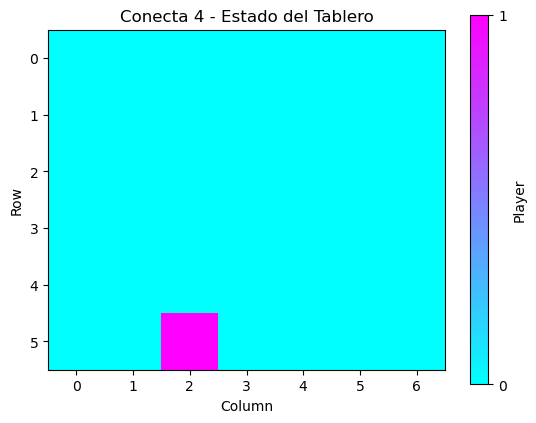

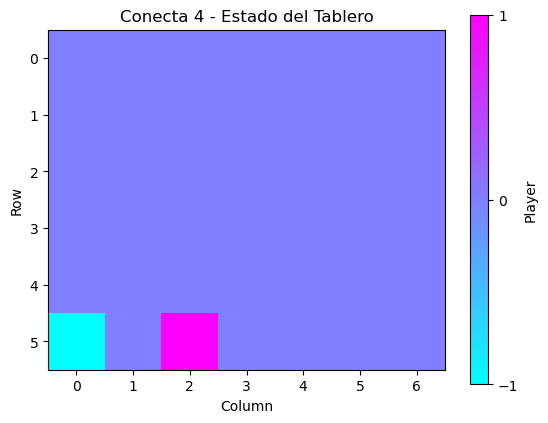

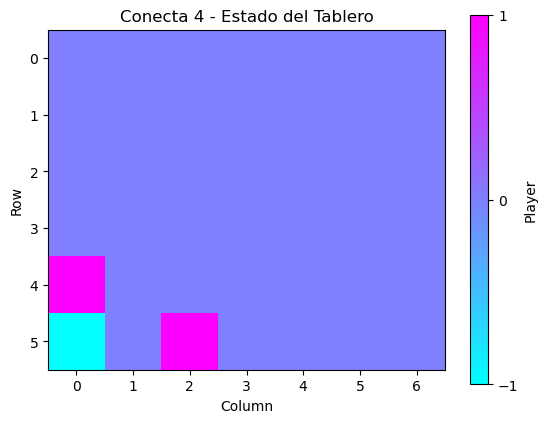

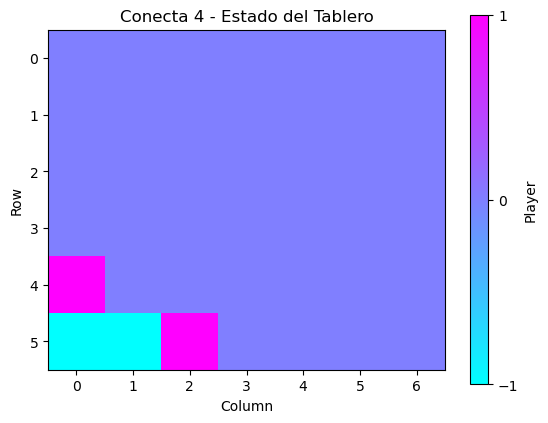

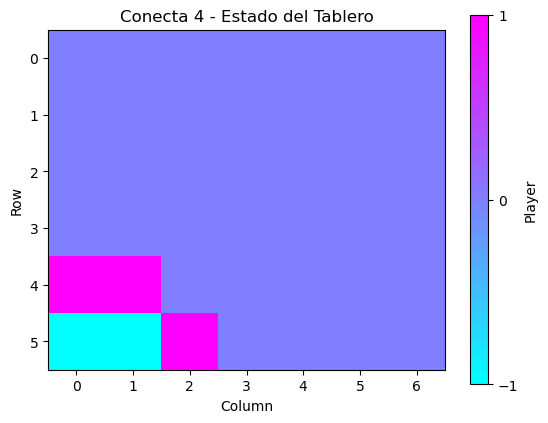

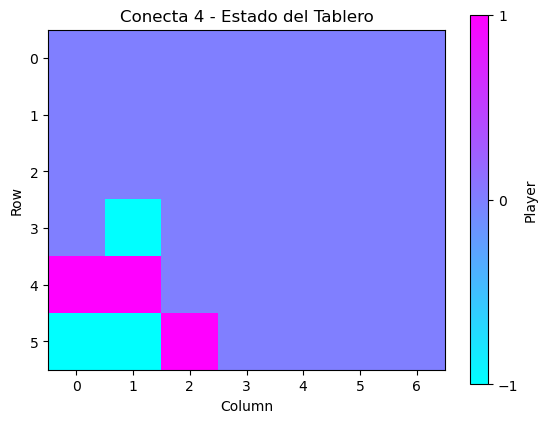

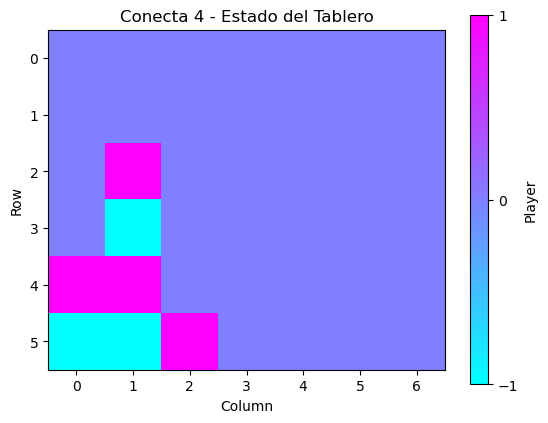

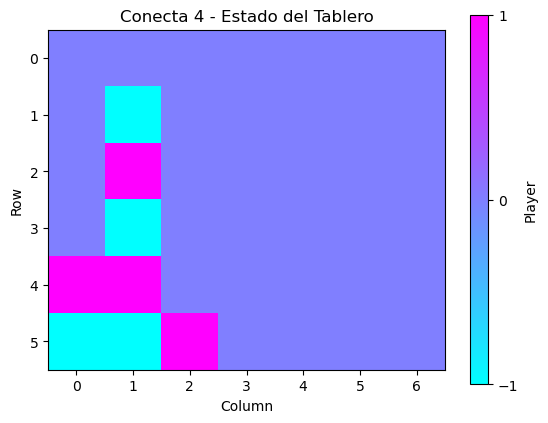

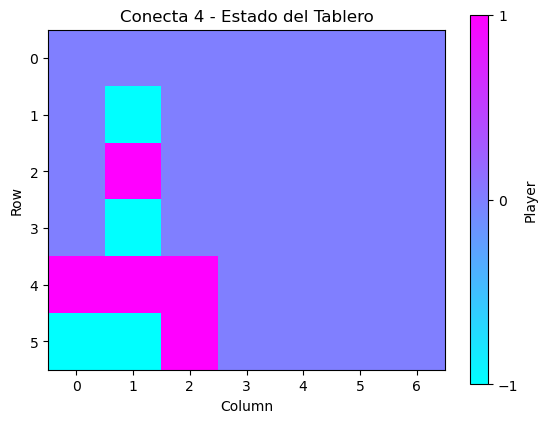

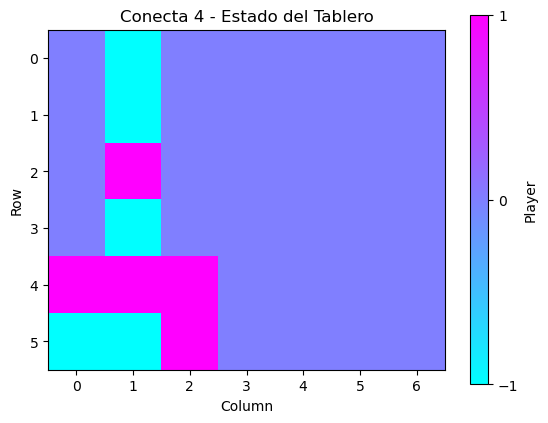

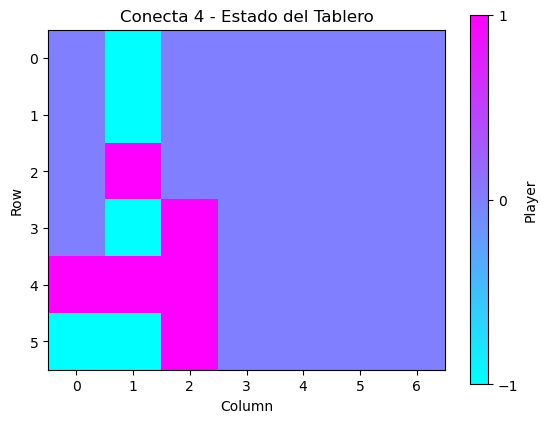

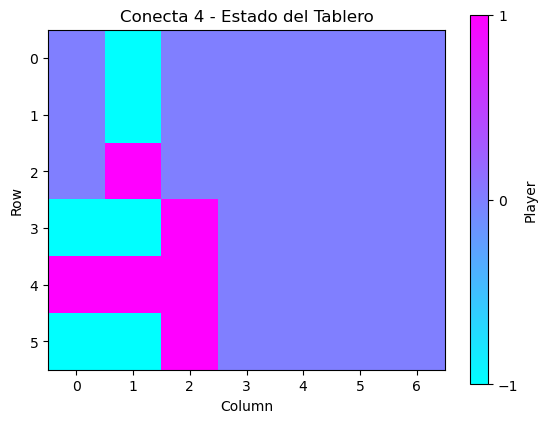

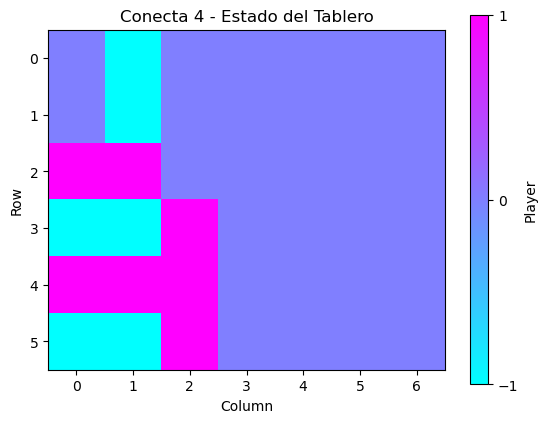

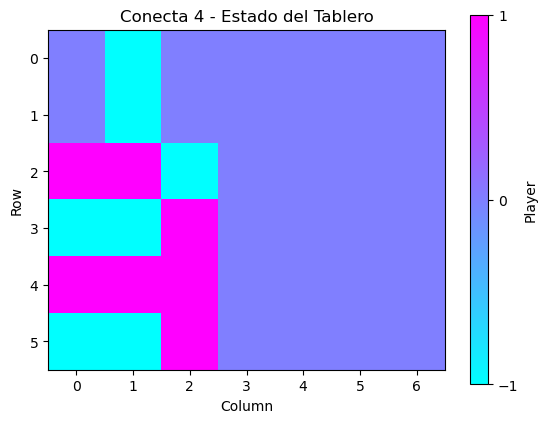

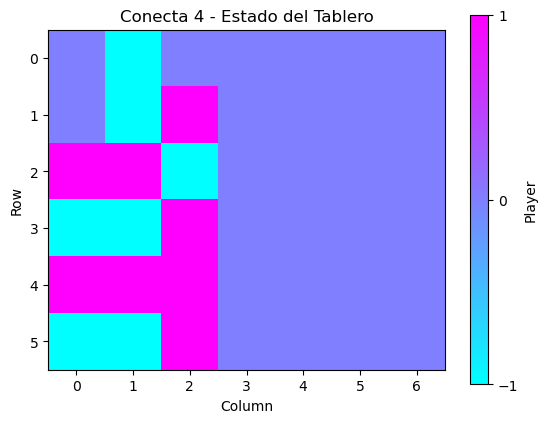

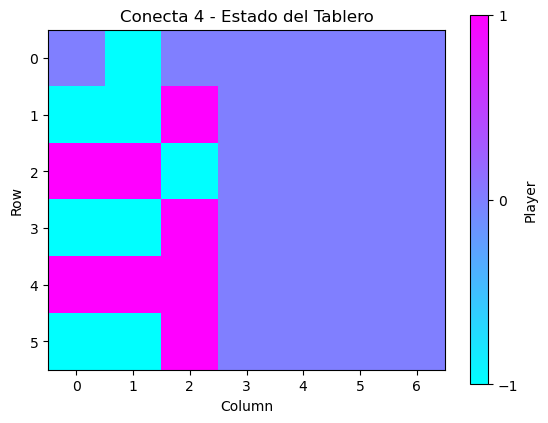

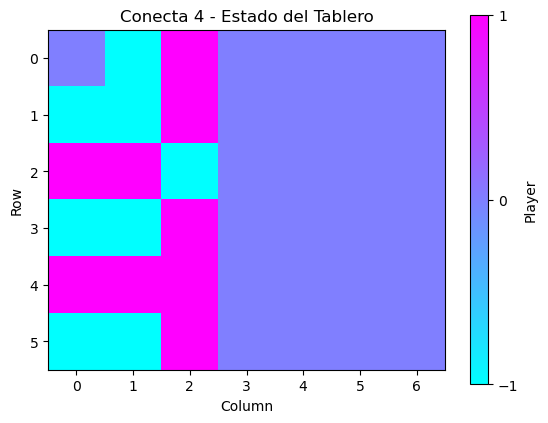

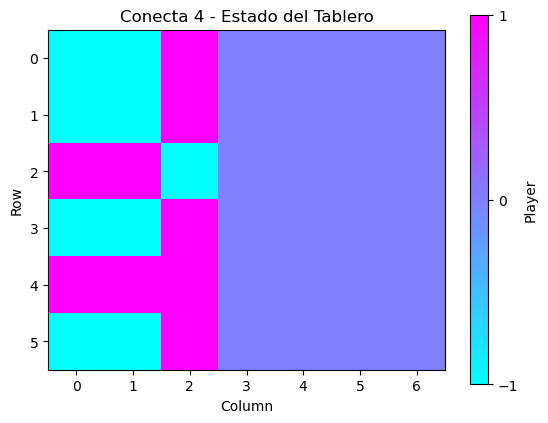

Empate


In [73]:

# Example of starting a game with a human vs AI setup
player1 = AIPlayer(1)  # AI player
player2 = AIPlayer(-1)  # AI player as opponent for demonstration (can replace with a human player class)

game = Game(player1, player2)
game.board.reset()

# Simulate a single game between two AI players, displaying the board after each move
game_over = False
while not game_over:
    for player in game.players:
        action = player.move(game.board)
        game.board.update(player.symbol, action)
        display_board(game.board.state)
        if game.board.is_game_over() is not None:
            game_over = True
            break

winner = game.board.is_game_over()
if winner == 0:
    print("Empate")
elif winner == 1:
    print("Jugador 1 (IA) gana")
else:
    print("Jugador 2 (IA) gana")
    

In [74]:

import numpy as np
import random

class QLearningAI:
    def __init__(self, symbol, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.symbol = symbol
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = {}  # Stores Q-values for state-action pairs

    def get_state_key(self, board):
        # Convert the board state to a tuple to use as a key in the Q-table
        return tuple(map(tuple, board.state))

    def move(self, board):
        state_key = self.get_state_key(board)
        if random.uniform(0, 1) < self.exploration_rate:  # Explore
            action = random.choice(board.valid_moves())
        else:  # Exploit
            q_values = self.q_table.get(state_key, np.zeros(board.cols))
            action = int(np.argmax(q_values))
        return action

    def update_q_table(self, old_state, action, reward, new_state):
        old_state_key = self.get_state_key(old_state)
        new_state_key = self.get_state_key(new_state)
        
        # Initialize Q-values if state-action pair is new
        if old_state_key not in self.q_table:
            self.q_table[old_state_key] = np.zeros(old_state.cols)
        if new_state_key not in self.q_table:
            self.q_table[new_state_key] = np.zeros(old_state.cols)

        # Update Q-value with Q-learning formula
        best_future_q = np.max(self.q_table[new_state_key])
        self.q_table[old_state_key][action] = self.q_table[old_state_key][action] + self.learning_rate *             (reward + self.discount_factor * best_future_q - self.q_table[old_state_key][action])

    def reset(self):
        self.exploration_rate *= self.exploration_decay  # Reduce exploration over time

    def reward(self, reward_value):
        pass  # Placeholder, not used in the current structure
    

In [75]:
class Game:
    def __init__(self, player1, player2, rows=6, columns=7):
        player1.symbol = 1
        player2.symbol = -1
        self.players = [player1, player2]
        self.board = Board(rows, columns)  # Crear el tablero con las dimensiones dadas

# Ajustar entrenamiento para permitir partidas entre Q-learning AI y una AI aleatoria
player1 = QLearningAI(1)  # Q-learning AI
player2 = AIPlayer(-1)    # Oponente AI simple y aleatorio

episodes = 1000  # Define el número de episodios de entrenamiento
rows, columns = 6, 7  # Dimensiones del tablero 6x7

for episode in range(episodes):
    game = Game(player1, player2)
    game.board = Board(rows, columns)  # Crea el tablero con las dimensiones 6x7
    game.board.reset()
    game_over = False
    state_history = []

    while not game_over:
        for player in game.players:
            current_state = game.board.copy()
            action = player.move(game.board)
            game.board.update(player.symbol, action)
            new_state = game.board.copy()
            state_history.append((current_state, action, player.symbol))

            # Comprobar si el juego ha terminado y asignar recompensas
            result = game.board.is_game_over()
            if result is not None:
                game_over = True
                if result == 0:  # Empate
                    reward = 0
                elif result == player1.symbol:  # Gana la IA de Q-learning
                    reward = 1
                else:  # Pierde la IA de Q-learning
                    reward = -1

                # Actualizar valores Q en función del resultado
                for old_state, action, symbol in reversed(state_history):
                    if symbol == player1.symbol:
                        player1.update_q_table(old_state, action, reward, new_state)
                    reward = -reward  # Invierte la recompensa para la perspectiva del otro jugador
                break

    player1.reset()  # Reducir la tasa de exploración después de cada episodio

# Mostrar que el entrenamiento ha finalizado
print("Entrenamiento completado para", episodes, "episodios.")


TypeError: Board.__init__() takes 1 positional argument but 3 were given